In [1]:
from transformers import ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset
import numpy as np
import torch


In [2]:
client  = QdrantClient(host="localhost", port=6333)

In [3]:
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE)
)

True

## Image embeddings

In [4]:
dataset = load_dataset("marmal88/skin_cancer", split="train")
dataset

Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 9577
})

In [5]:
dataset[8500]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0025927',
 'lesion_id': 'HAM_0002557',
 'dx': 'melanoma',
 'dx_type': 'histo',
 'age': 50.0,
 'sex': 'female',
 'localization': 'upper extremity'}

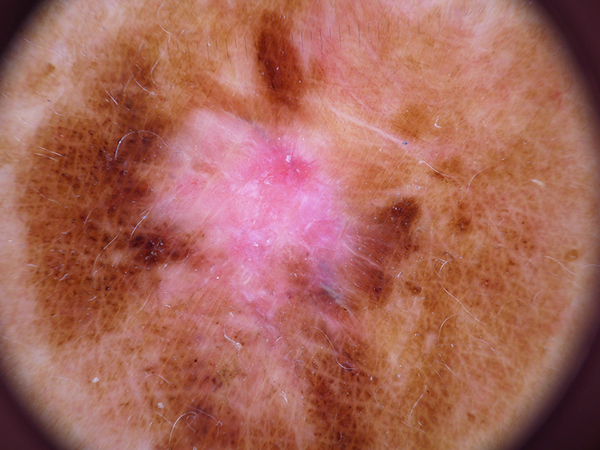

In [6]:
image = dataset[8500]["image"]
image

In [7]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

mps_device
cpu_device = torch.device("cpu")

In [8]:
processor = ViTImageProcessor.from_pretrained("facebook/dino-vits16")
model = ViTModel.from_pretrained("facebook/dino-vits16").to(mps_device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
inputs = processor(images=np.array(image), return_tensor="pt").to(mps_device)
inputs["pixel_values"].shape, inputs

(torch.Size([1, 3, 224, 224]),
 {'pixel_values': tensor([[[[-1.3987, -1.4329, -1.4500,  ..., -1.0904, -1.1075, -1.0904],
           [-1.4158, -1.4329, -1.4500,  ..., -1.0904, -1.1075, -1.1075],
           [-1.4329, -1.4500, -1.4500,  ..., -1.1247, -1.1075, -1.1075],
           ...,
           [-1.1075, -1.1075, -1.0904,  ..., -1.4843, -1.5014, -1.5357],
           [-1.1075, -1.1075, -1.0904,  ..., -1.4843, -1.5185, -1.5528],
           [-1.1247, -1.1247, -1.0904,  ..., -1.4843, -1.5357, -1.5528]],
 
          [[-1.7381, -1.7381, -1.7556,  ..., -1.5980, -1.6155, -1.6331],
           [-1.7381, -1.7381, -1.7556,  ..., -1.6155, -1.6331, -1.6506],
           [-1.7381, -1.7381, -1.7556,  ..., -1.5980, -1.6155, -1.6155],
           ...,
           [-1.5630, -1.5630, -1.5630,  ..., -1.7731, -1.7906, -1.7906],
           [-1.5630, -1.5630, -1.5630,  ..., -1.7906, -1.7906, -1.8081],
           [-1.5805, -1.5805, -1.5630,  ..., -1.7906, -1.8081, -1.8081]],
 
          [[-1.3513, -1.3687, -1.3861,

In [11]:
one_embedding = model(**inputs).last_hidden_state
one_embedding.shape, one_embedding[0, 0, :20]

(torch.Size([1, 197, 384]),
 tensor([ 3.0854,  4.9196, -1.1094,  3.3949, -0.8139,  4.8751,  4.4032, -0.6903,
          5.5181,  8.6680,  1.6411,  5.6704,  2.2703, -1.3895, -1.8102, -1.4204,
          8.9997,  8.5076,  5.1398, -7.1862], device='mps:0',
        grad_fn=<SliceBackward0>))

In [12]:
one_embedding.mean(dim=1).shape

torch.Size([1, 384])

In [13]:
def get_embeddings(batch):
    inputs = processor(images=batch["image"], return_tensors="pt").to(mps_device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    batch["embeddings"] = outputs
    return batch

In [15]:
dataset = (
    dataset.shuffle(42)
        .select(range(1000))
        .map(get_embeddings, batched=True, batch_size=16)
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
dataset

Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'embeddings'],
    num_rows: 1000
})

In [18]:
np.save("vectors", np.array(dataset["embeddings"]), allow_pickle=False)

In [20]:
payload = dataset.select_columns([
    "image_id" , "dx", "dx_type", "age", "sex", "localization"
]).to_pandas().fillna({"age": 0}).to_dict(orient="records")

payload[:3]

[{'image_id': 'ISIC_0028370',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 60.0,
  'sex': 'male',
  'localization': 'face'},
 {'image_id': 'ISIC_0031642',
  'dx': 'melanoma',
  'dx_type': 'histo',
  'age': 50.0,
  'sex': 'female',
  'localization': 'back'},
 {'image_id': 'ISIC_0031967',
  'dx': 'benign_keratosis-like_lesions',
  'dx_type': 'histo',
  'age': 70.0,
  'sex': 'female',
  'localization': 'scalp'}]

In [22]:
ids = list(range(dataset.num_rows))
embeddings = np.load("vectors.npy").tolist()

In [23]:
batch_size = 1000

for i in range(0, dataset.num_rows, batch_size):
    low_idx = min(i+batch_size, dataset.num_rows)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads,
        )
    )


In [24]:
client.count(
    collection_name=my_collection,
    exact=True
)

CountResult(count=1000)

In [27]:
client.scroll(
    collection_name=my_collection,
    with_vectors=True,
    limit=5
)

([Record(id=0, payload={'age': 60.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0028370', 'localization': 'face', 'sex': 'male'}, vector=[-0.02940647, -0.068967775, 0.025144532, 0.01803116, -0.026546737, -0.0435791, -0.0060278745, 0.004292573, 0.0193067, -0.002862988, -0.025554435, -0.056134492, 0.04838837, -0.0052471436, 0.017891308, -0.02368451, 0.01692436, -0.045521665, -0.05090726, -0.010260492, 0.027031308, -0.015421253, -0.043593656, 0.036822353, -0.0152070625, -0.036205377, 0.070351556, -0.030195596, -0.008895723, -0.0033371954, 0.026375057, 0.08800005, -0.0190466, -0.015740652, 0.06084812, -0.019560939, 0.008038403, 0.063566454, 0.066478245, -0.01675024, -0.05618638, -0.016945068, -0.017507553, -0.0382058, -0.01908272, -0.04881044, 0.013838425, -0.03427192, 0.08345796, 0.04742854, -0.06574525, 0.012087948, 0.0101477895, -0.032809544, 0.00901433, -0.049306408, -0.019823214, 0.0043630474, 0.09655131, 0.08327969, -0.05233885, 0.14171323, 0.0047223694, -0.0135

## 4. Semantic search

In [28]:
client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    limit=10
)

[ScoredPoint(id=322, version=0, score=0.895756, payload={'age': 55.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'histo', 'image_id': 'ISIC_0024471', 'localization': 'upper extremity', 'sex': 'male'}, vector=None, shard_key=None),
 ScoredPoint(id=673, version=0, score=0.8951478, payload={'age': 20.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0028636', 'localization': 'abdomen', 'sex': 'female'}, vector=None, shard_key=None),
 ScoredPoint(id=77, version=0, score=0.8950585, payload={'age': 85.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_id': 'ISIC_0032870', 'localization': 'upper extremity', 'sex': 'male'}, vector=None, shard_key=None),
 ScoredPoint(id=532, version=0, score=0.88911504, payload={'age': 70.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_id': 'ISIC_0026188', 'localization': 'trunk', 'sex': 'male'}, vector=None, shard_key=None),
 ScoredPoint(id=596, version=0, score=0.8859706, payload={'age': 65.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_

In [29]:
female_older_than_55 = models.Filter(
    must=[
        models.FieldCondition(key="sex", match=models.MatchValue(value="female")),
    ],
    should=[
        models.FieldCondition(key="age", range=models.Range(lt=None, gt=None, gte=55.0, lte=None))
    ]
)

In [31]:
results = client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    query_filter=female_older_than_55,
    limit=10
)
results

[ScoredPoint(id=598, version=0, score=0.87650084, payload={'age': 70.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0030297', 'localization': 'face', 'sex': 'female'}, vector=None, shard_key=None),
 ScoredPoint(id=516, version=0, score=0.8737834, payload={'age': 55.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0034254', 'localization': 'back', 'sex': 'female'}, vector=None, shard_key=None),
 ScoredPoint(id=717, version=0, score=0.8609968, payload={'age': 70.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'consensus', 'image_id': 'ISIC_0025654', 'localization': 'back', 'sex': 'female'}, vector=None, shard_key=None),
 ScoredPoint(id=828, version=0, score=0.86026037, payload={'age': 75.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'consensus', 'image_id': 'ISIC_0027826', 'localization': 'face', 'sex': 'female'}, vector=None, shard_key=None),
 ScoredPoint(id=978, version=0, score=0.8593559, payload={'age': 70.0, 'dx': 'benign_keratosis-

In [34]:
def see_images(results, top_k=5):
    for i in range(top_k):
        image_id = results[i].payload["image_id"]
        score    = results[i].score
        dx       = results[i].payload["dx"]
        gender   = results[i].payload["sex"]
        age      = results[i].payload["age"]
        image    = dataset.filter(
            lambda x: x == image_id, input_columns="image_id"
        ).select_columns("image")[0]["image"]
        print(f"Result #{i+1}: {gender} age {age} was diagnosed with {dx}")
        print(f"This image score was {score}")
        display(image)
        print("=" * 50)
        print()

Result #1: female age 70.0 was diagnosed with actinic_keratoses
This image score was 0.87650084


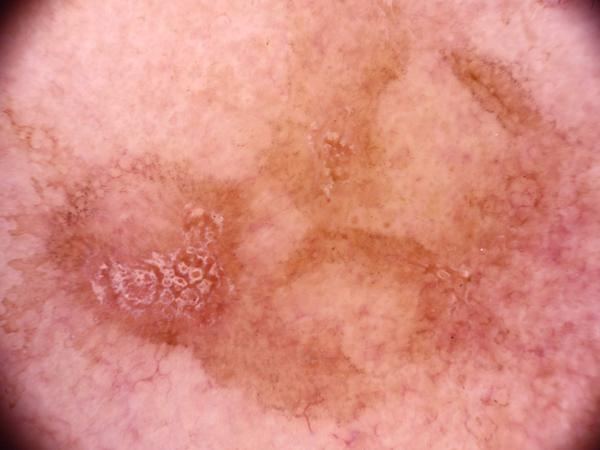

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Result #2: female age 55.0 was diagnosed with melanocytic_Nevi
This image score was 0.8737834


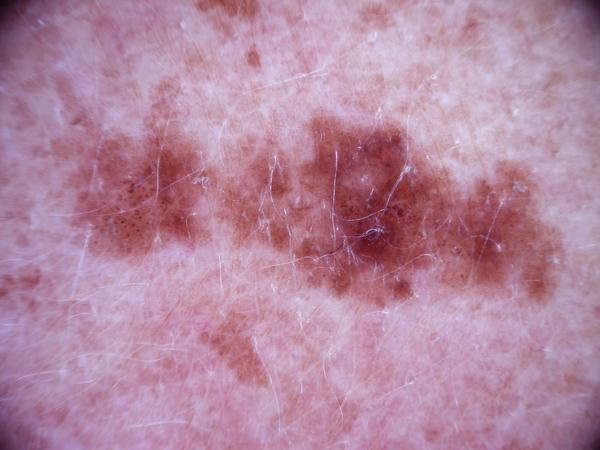

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Result #3: female age 70.0 was diagnosed with benign_keratosis-like_lesions
This image score was 0.8609968


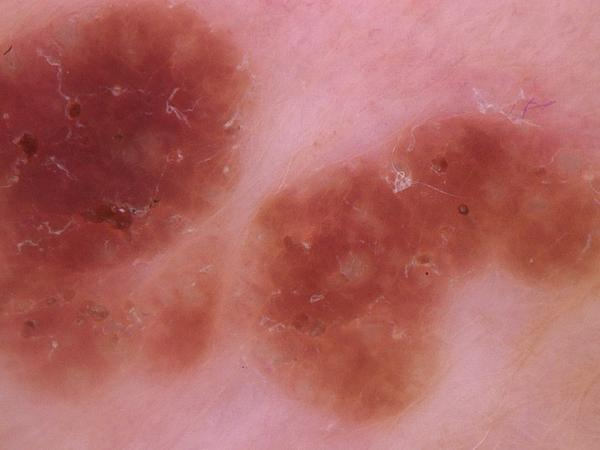

In [35]:
see_images(results, 3)